# Prompt Explorer

This is a notebook for exploring prompts and seeds. Random seeds are generated and displayed. The idea is to have this running alongside other more complicated notebooks, but this one doesn't needs to have gdrive connection. Then when finding cool prompt/seed combos, but them in the prompts google sheet and have those more complex notebooks reference the sheet vs defining prompts as variables in the code.

In [46]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/gdrive')

song_name = 'cycle' #@param {type:"string"}
res_height = 576 #@param
res_width = 1024 #@param

code_folder = '/content/gdrive/MyDrive/AI-Art Kyle'

# fp = os.path.join(code_folder, 'input_data.xlsx')
# df_prompt = pd.read_excel(fp, 'prompts_{}'.format(song_name), index_col=0).dropna(how='all')
# df_prompt

fp = os.path.join(code_folder, song_name, 'prompt_data', 'prompt_image_definitions.csv')
df_prompt = pd.read_csv(fp, index_col=0).dropna(how='all')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%%capture
!pip install diffusers
!pip install transformers scipy ftfy accelerate

import torch
from diffusers import StableDiffusionPipeline

In [6]:

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1",
                                               torch_dtype=torch.float16,
                                               safety_checker=None
                                               )


pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [65]:
fp = os.path.join(code_folder, song_name, 'prompt_data', 'prompt_image_definitions.csv')
df_prompt = pd.read_csv(fp, index_col=0).dropna(how='all')
df_prompt

prompt  \
name                                                                 
crumbles_aerial  an aerial view of a city with crumbling buildi...   
crumbles_1       a city with crumbling buildings and rubble on ...   
growth           a city with crumbling buildings, plants growin...   
solarpunk        a solarpunk city, exuberant plant life, plants...   
solarpunk2       a solarpunk city, exuberant plant life, monstr...   

                negative_prompt  \
name                              
crumbles_aerial             NaN   
crumbles_1                  NaN   
growth                      NaN   
solarpunk                   NaN   
solarpunk2               window   

                                                             seeds  \
name                                                                 
crumbles_aerial  3510403871625230, 1495997141297107, 2060481474...   
crumbles_1       3510403871625230, 1495997141297107, 2060481474...   
growth           3510403871625230, 1495997141297107, 2060481474...   
solarpunk        3510403871625230, 1495997141297107, 2060481474...   
solarpunk2                                                     NaN   

                 guidance_scale  
name                             
crumbles_aerial             7.5  
crumbles_1                  7.5  
growth                      7.5  
solarpunk                   7.5  
solarpunk2                  7.5

Prompt: a solarpunk city, exuberant plant life, plants growing off buildings, vertical gardening
Seeds: [2203341424839939, 7696964535120341, 8073992389477540, 6313153470100406]


  0%|          | 0/50 [00:00<?, ?it/s]

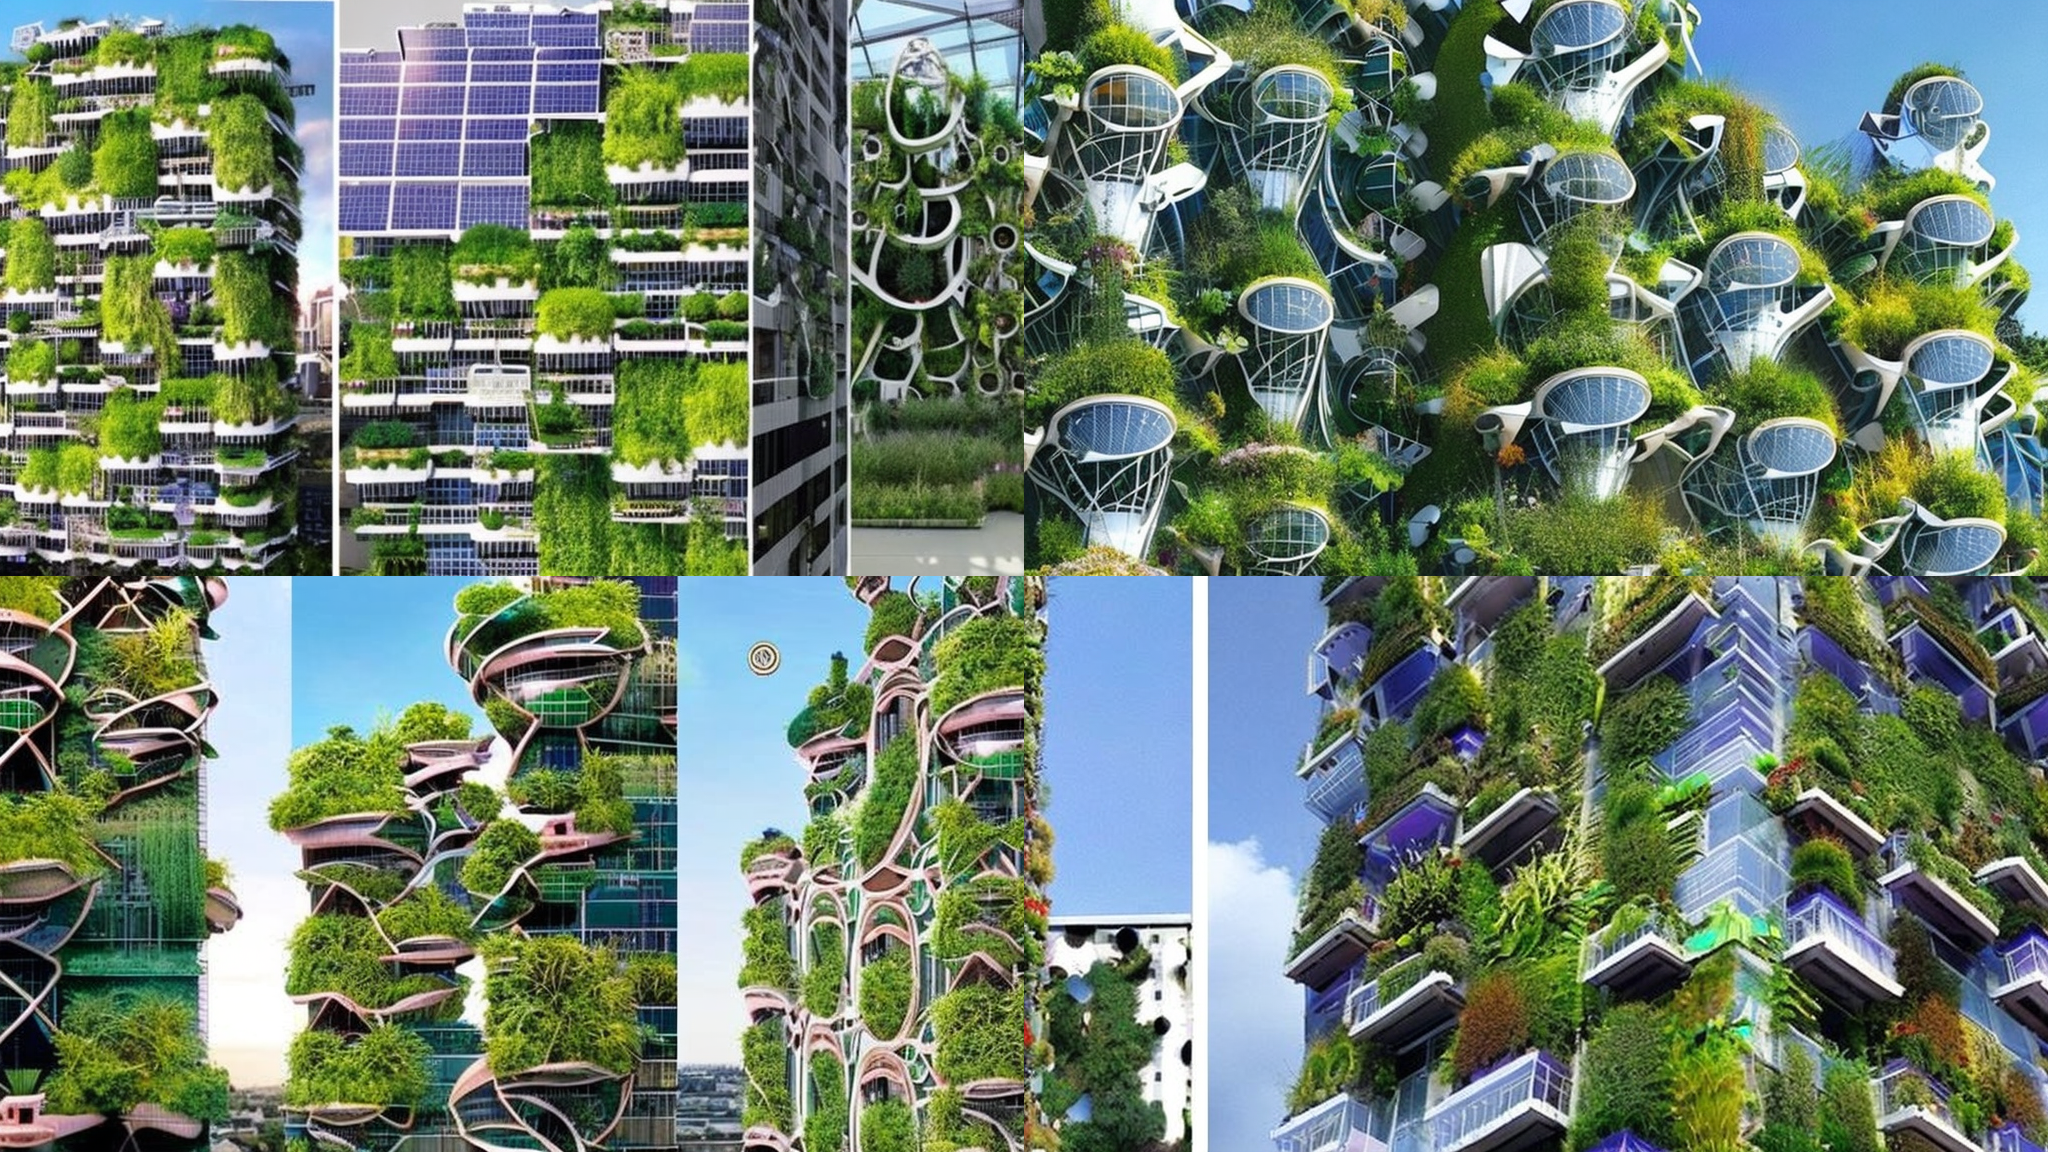

In [71]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


# # https://huggingface.co/docs/diffusers/using-diffusers/reusing_seeds

prompt_name = 'solarpunk'
prompt = df_prompt['prompt'][prompt_name]
guidance_scale = float(df_prompt['guidance_scale'][prompt_name])
negative_prompt = df_prompt['negative_prompt'][prompt_name]
if negative_prompt != negative_prompt: negative_prompt = None

# prompt_components = [
#     "a floating tram",
#     "descending into an alien world",
#     "Matte Painting",
#     "retrowave color scheme",
#     "purple orange yellow maroon",
#     "full view of vehicle",
# ]

# prompt = ", ".join(prompt_components)

# rows X cols of images. Reduce for speed and memory issues.
rows = 2
cols = 2

num_images = rows*cols

# Make new random seeds in a hacky way. TODO: probably a function to generate seeds without making a generator instance.

generator = torch.Generator(device="cuda")
# seeds = [generator.seed() for i in range(num_images)]
seeds = [2203341424839939, 7696964535120341, 8073992389477540, 6313153470100406]
generator = [torch.Generator(device="cuda").manual_seed(seed) for seed in seeds]

print("Prompt: {}".format(prompt))
print("Seeds: {}".format(seeds))

images = pipe(prompt, generator=generator, num_images_per_prompt=rows*cols, guidance_scale=guidance_scale, negative_prompt=negative_prompt, width=res_width, height=res_height).images

image_grid(images, rows=rows, cols=cols)